# STEP 1 - Central Model Evaluation

First, a central model needs to be found and evaluated.
It is important to figure out the best features, their engineering, hyperparams and so on.
The final model can then be transferred into a federated learning model and be executed on the Raspberry Pis.

## Imports

In [1]:
import nest_asyncio

nest_asyncio.apply()

import collections
import functools
import os
import time
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import pandas as pd
import numpy as np

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [2]:
# Test the TFF is working:
tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

## First Model

The first model is a simple test run.
It is supposed to predict the category based on only the temporal features.
Therefore, we drop the user column.

In [3]:
df = pd.read_csv("./4square/processed_transformed.csv")
df.head(100)

,cat_id,user_id,clock_sin,clock_cos,day_sin,day_cos,month_sin,month_cos,week_day_sin,week_day_cos
0,0,470,-1.000000,0.000654,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
1,1,979,-0.999998,0.001818,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
2,2,69,-0.999945,0.010472,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
3,3,395,-0.999931,0.011708,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
4,4,87,-0.999914,0.013090,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
...,...,...,...,...,...,...,...,...,...,...
95,7,445,-0.959601,0.281365,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
96,6,235,-0.956326,0.292302,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
97,8,118,-0.955729,0.294249,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
98,2,1054,-0.955407,0.295291,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349


In [4]:
df.drop(['user_id'], axis=1, inplace=True)
df.head(10)

,cat_id,clock_sin,clock_cos,day_sin,day_cos,month_sin,month_cos,week_day_sin,week_day_cos
0,0,-1.000000,0.000654,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
1,1,-0.999998,0.001818,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
2,2,-0.999945,0.010472,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
3,3,-0.999931,0.011708,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
4,4,-0.999914,0.013090,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
5,5,-0.999848,0.017452,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
6,6,-0.999796,0.020215,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
7,7,-0.999790,0.020506,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
8,2,-0.999622,0.027485,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
9,8,-0.999620,0.027558,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349


A typical 80/10/0 (train/valid/test) split is executed.

In [5]:
train, test = train_test_split(df, test_size=0.2, shuffle=False)
train, val = train_test_split(train, test_size=0.2, shuffle=False)

print(len(train), 'train size')
print(len(val), 'validation size')
print(len(test), 'test size')

145553 train size
36389 validation size
45486 test size


In [6]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=False, batch_size=32):
  dataframe = df.copy()
  labels = dataframe.pop('cat_id')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [7]:
# Create the training dataset
train_ds = df_to_dataset(train)

# Create the validation dataset
val_ds = df_to_dataset(val, shuffle=False)

# Create the test dataset
test_ds = df_to_dataset(test, shuffle=False)

In [8]:
# the number of different categories defines the vocabulary size
categories = df.cat_id
vocab_size = categories.nunique()

print('vocabulary size:', vocab_size)

vocabulary size: 27


All the numerical column names are needed for to process feature columns.
We create a model for a NN with two layers with 128 neurons each and one layer with the size of the vocab at the end.
Relu is used as the activation function.
A softmax layer is used to generate the output.
All in all, this is a simple NN as we only need to predict the category for the given time.

In [9]:
# List of numerical column names
numerical_column_names = ['clock_sin', 'clock_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'week_day_sin', 'week_day_cos']

In [10]:
# Create a model
def create_model():
  # List of numeric feature columns to pass to the DenseLayer
  feature_columns = []
  # Shortcut to the layers package
  l = tf.keras.layers

  # Handling numerical columns
  for header in numerical_column_names:
    # Append all the numerical columns defined into the list
    feature_columns.append(feature_column.numeric_column(header))

  # Keras will receive the dictionary as 'x'
  # The dictionary contains as key the column names and the value is the Keras input layer
  # This is a model with multiple inputs, so we need to declare an input layer for each feature
  feature_inputs={}
  for c_name in numerical_column_names:
    feature_inputs[c_name] = tf.keras.Input((1,), name=c_name)

  # define a DenseFeature layer for the numeric columns
  numerical_features = l.DenseFeatures(feature_columns)(feature_inputs)

  # hidden layer with 128 neurons
  dense = l.Dense(128, kernel_initializer='he_uniform', activation='relu')(numerical_features)

  # another hidden layer with 128 neurons
  dense_1 = l.Dense(128, kernel_initializer='he_uniform', activation='relu')(dense)

  # Last layer with an output for each category (vocab)
  dense_2 = layers.Dense(vocab_size)(dense_1)

  # Softmax layer
  output = l.Softmax()(dense_2)

  # To return the Model, we need to define its inputs and outputs
  inputs = list(feature_inputs.values())

  # Return the Model
  return tf.keras.Model(inputs=inputs, outputs=output)

Here, the model summary can be seen.

In [11]:
# Create the model
model = create_model()

# Define an optimizer
adam = tf.keras.optimizers.Adam(lr=0.002)

# Compile the model with optimizer, loss and metrics
model.compile(optimizer = adam,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

# Print the model summary
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
clock_cos (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
clock_sin (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
day_cos (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
day_sin (InputLayer)            [(None, 1)]          0                                            
_______________________________________________________________________________________

The model can also be plotted to have a visualisation.

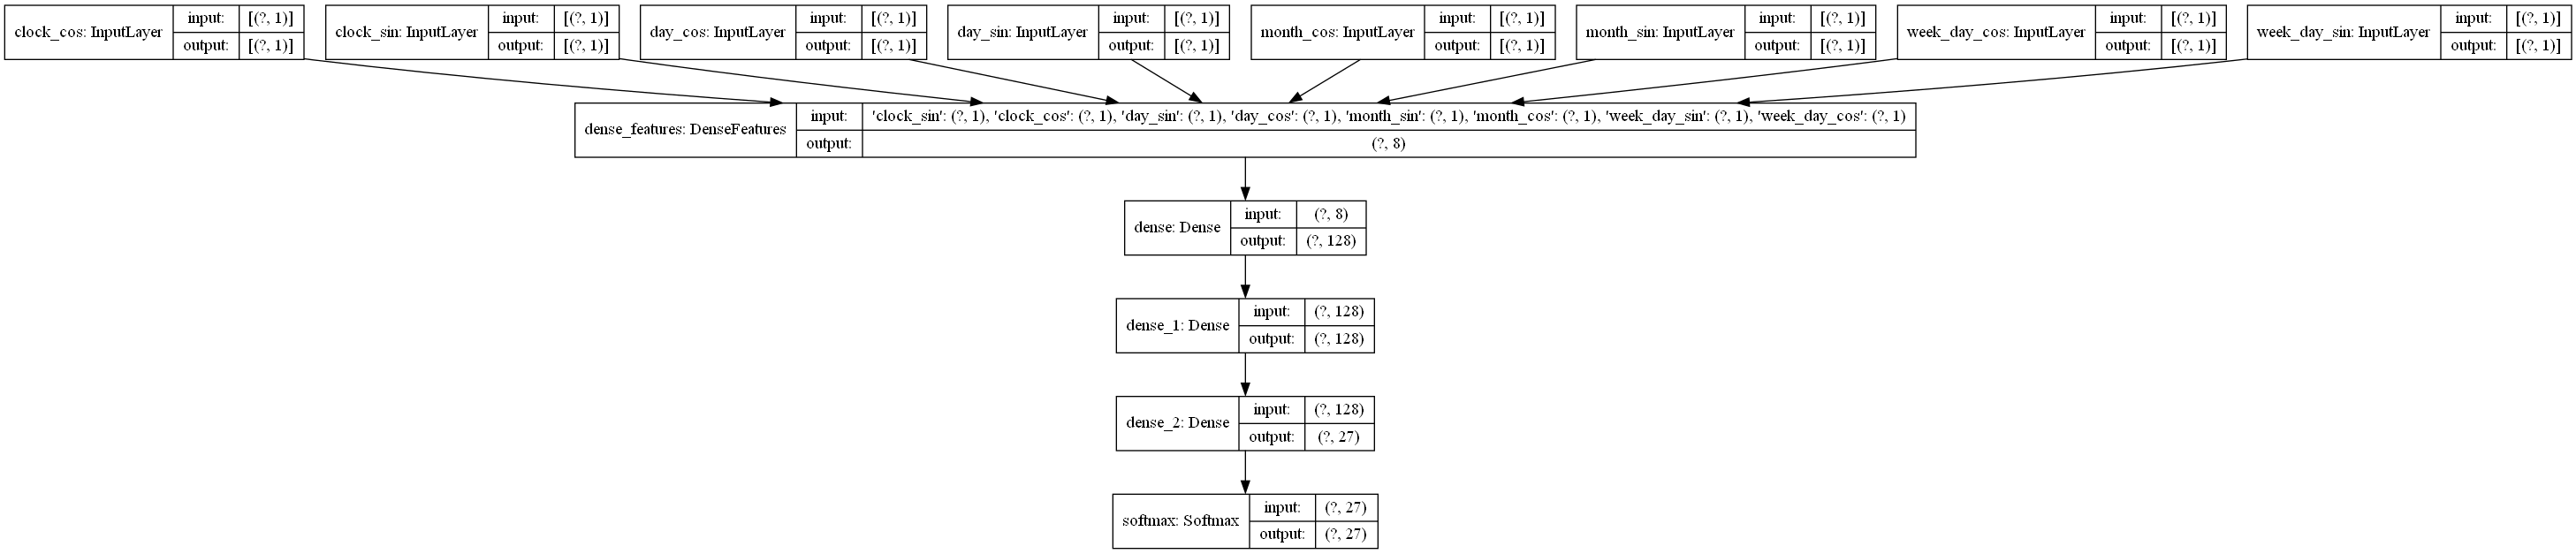

In [12]:
# Plot
from tensorflow.keras.utils import plot_model
plot_model(model, '4square-1-first-model.png', show_shapes=True)

The model is now trained for 20 epochs.

In [13]:
N_EPOCHS = 20
# Train
model.fit(train_ds,
          validation_data=val_ds,
          epochs=N_EPOCHS)

Epoch 1/20
7108/7108 [==============================] - 7s 1ms/step - loss: 3.1779 - sparse_categorical_accuracy: 0.1786 - val_loss: 3.1710 - val_sparse_categorical_accuracy: 0.1860
Epoch 2/20
7108/7108 [==============================] - 7s 990us/step - loss: 3.1688 - sparse_categorical_accuracy: 0.1882 - val_loss: 3.1690 - val_sparse_categorical_accuracy: 0.1881
Epoch 3/20
7108/7108 [==============================] - 7s 975us/step - loss: 3.1669 - sparse_categorical_accuracy: 0.1902 - val_loss: 3.1661 - val_sparse_categorical_accuracy: 0.1911
Epoch 4/20
7108/7108 [==============================] - 7s 984us/step - loss: 3.1673 - sparse_categorical_accuracy: 0.1900 - val_loss: 3.1660 - val_sparse_categorical_accuracy: 0.1913
Epoch 5/20
7108/7108 [==============================] - 7s 982us/step - loss: 3.1660 - sparse_categorical_accuracy: 0.1914 - val_loss: 3.1638 - val_sparse_categorical_accuracy: 0.1935
Epoch 6/20
7108/7108 [==============================] - 7s 987us/step - loss: 3.16

The evaluation on the test data is executed and the accuracy is printed.

In [14]:
# Evaluation
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

7108/7108 [==============================] - 3s 459us/step - loss: 3.1662 - sparse_categorical_accuracy: 0.1912
Accuracy 0.19120337069034576


As expected, with such a simple approach, the accuracy is quite low.


## Second Model
The second model looks at the data in sequences of a fixed length N.
The data is split for each user and then in chunks of the size N.
Then, the prediction looks back at the given history and uses that information to make a prediction.
This should increase the prediction quality and thus result in a higher accuracy at the end.

In [15]:
df = pd.read_csv("./4square/processed_transformed.csv")
df.head(100)

,cat_id,user_id,clock_sin,clock_cos,day_sin,day_cos,month_sin,month_cos,week_day_sin,week_day_cos
0,0,470,-1.000000,0.000654,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
1,1,979,-0.999998,0.001818,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
2,2,69,-0.999945,0.010472,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
3,3,395,-0.999931,0.011708,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
4,4,87,-0.999914,0.013090,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
...,...,...,...,...,...,...,...,...,...,...
95,7,445,-0.959601,0.281365,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
96,6,235,-0.956326,0.292302,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
97,8,118,-0.955729,0.294249,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349
98,2,1054,-0.955407,0.295291,0.587785,0.809017,0.866025,-0.5,0.781831,0.62349


It is best, to use only the best 100 users for this purpose.
As they have the longest sequences of visited places.

In [16]:
count = df.user_id.value_counts()

idx = count.loc[count.index[:100]].index # count >= 100
df = df.loc[df.user_id.isin(idx)]

An array is created containing all visited locations for every user.
The original data is sorted by time (ascending).
Thus, the array contains a sequence of visited location categories by user.

In [17]:
# List the df for each user
users_locations = []

# For each user
for user_id in tqdm(idx):
  users_locations.append(df.loc[df.user_id == user_id].copy())

100%|██████████| 100/100 [00:00<00:00, 2856.88it/s]


It is necessary to first split the data in train, valid and test for each user.
Then, these are merged together again later on.
This is done to ensure that the sequences are kept together and not split randomly for the users.

In [18]:
# List the dfs fo train, val and test for each user
users_locations_train = []
users_locations_val = []
users_locations_test = []

for user_df in users_locations:
  # Split in train, test and validation
  train, test = train_test_split(user_df, test_size=0.2, shuffle=False)
  train, val = train_test_split(train, test_size=0.2, shuffle=False)

  # Append the sets
  users_locations_train.append(train)
  users_locations_val.append(val)
  users_locations_test.append(test)

A quick analysis on the number of locations of our users.

In [19]:
sizes = []
# Number of locations for each user
for user_df in users_locations:
  sizes.append(user_df.shape[0])

print('Training')
print('Mean number of locations: ', np.mean(np.array(sizes)))
print('Max number of locations: ', np.max(np.array(sizes)))
print('Min number of locations: ', np.min(np.array(sizes)))

Training
Mean number of locations:  644.66
Max number of locations:  2697
Min number of locations:  387


In [20]:
sizes = []
# Number of locations for each user in the validation set
for user_df in users_locations_val:
  sizes.append(user_df.shape[0])

print('Validation')
print('Mean number of locations: ', np.mean(np.array(sizes)))
print('Max number of locations: ', np.max(np.array(sizes)))
print('Min number of locations: ', np.min(np.array(sizes)))

Validation
Mean number of locations:  103.48
Max number of locations:  432
Min number of locations:  62


In [21]:
sizes = []
# Number of locations for each user in the validation set
for user_df in users_locations_test:
  sizes.append(user_df.shape[0])

print('Mean number of locations: ', np.mean(np.array(sizes)))
print('Max number of locations: ', np.max(np.array(sizes)))
print('Min number of locations: ', np.min(np.array(sizes)))

Mean number of locations:  129.32
Max number of locations:  540
Min number of locations:  78


These values are as expected. The concatenation can be done.

In [22]:
# Merge back the dataframes
df_train = pd.concat(users_locations_train)

# Merge back the dataframes
df_val = pd.concat(users_locations_val)

# Merge back the dataframes
df_test = pd.concat(users_locations_test)

Sanity check: Was data lost when splitting and merging back together?

In [23]:
user_ids = df_train.user_id.unique()
print(user_ids.size)

100


No, everything is fine.
Now, the data has to be split in sequences of length N.
The following code is structured in methods, so the best value for N can be found.

Get the column names for the method below.

In [24]:
columns_names = df_train.columns.values
columns_names = np.delete(columns_names, np.where(columns_names == 'user_id'))
print(columns_names)

['cat_id' 'clock_sin' 'clock_cos' 'day_sin' 'day_cos' 'month_sin'
 'month_cos' 'week_day_sin' 'week_day_cos']


Tunable Parameters:

In [25]:
NUM_CLIENTS = user_ids.size
NUM_EPOCHS = 4
BATCH_SIZE = 16
#SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 5

Helper functions to split data, create clients dictionaries and preprocess the data for the FL algorithm.
The
 creation is also defined here.

In [26]:
# Split the data into chunks of N
def split_data(N):

  # dictionary of list of df
  df_dictionary = {}

  for uid in tqdm(user_ids):
    # Get the records of the user
    user_df_train = df_train.loc[df_train.user_id == uid].copy()
    user_df_val = df_val.loc[df_val.user_id == uid].copy()
    user_df_test = df_test.loc[df_test.user_id == uid].copy()

    # Get a list of dataframes of length N records
    user_list_train = [user_df_train[i:i+N] for i in range(0, user_df_train.shape[0], N)]
    user_list_val = [user_df_val[i:i+N] for i in range(0, user_df_val.shape[0], N)]
    user_list_test = [user_df_test[i:i+N] for i in range(0, user_df_test.shape[0], N)]

    # Save the list of dataframes into a dictionary
    df_dictionary[uid] = {
        'train': user_list_train,
        'val': user_list_val,
        'test': user_list_test
    }

  return  df_dictionary

In [27]:
# Takes a dictionary with train, validation and test sets and the desired set type
def create_clients_dict(df_dictionary, set_type, N):

  dataset_dict = {}

  for uid in tqdm(user_ids):

    c_data = collections.OrderedDict()
    values = df_dictionary[uid][set_type]

    # If the last dataframe of the list is not complete
    if len(values[-1]) < N:
      diff = 1
    else:
      diff = 0

    if len(values) > 0:
      # Create the dictionary to create a clientData
      for header in columns_names:
        c_data[header] = [values[i][header].values for i in range(0, len(values)-diff)]
      dataset_dict[uid] = c_data

  return dataset_dict

In [28]:
# preprocess dataset to tf format
def preprocess(dataset, N):

  def batch_format_fn(element):

    x=collections.OrderedDict()

    for name in columns_names:
      x[name]=tf.reshape(element[name][:, :-1], [-1, N-1])

    y=tf.reshape(element[columns_names[0]][:, 1:], [-1, N-1])

    return collections.OrderedDict(x=x, y=y)

  return dataset.repeat(NUM_EPOCHS).batch(BATCH_SIZE, drop_remainder=True).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [29]:
# create federated data for every client
def make_federated_data(client_data, client_ids, N):

  return [
      preprocess(client_data.create_tf_dataset_for_client(x), N)
      for x in tqdm(client_ids)
  ]

In [30]:
# Create a model
def create_keras_model(number_of_places, N, batch_size):

  # Shortcut to the layers package
  l = tf.keras.layers

  # List of numeric feature columns to pass to the DenseLayer
  numeric_feature_columns = []

  # Handling numerical columns
  for header in numerical_column_names:
		# Append all the numerical columns defined into the list
    numeric_feature_columns.append(feature_column.numeric_column(header, shape=N-1))

  feature_inputs={}
  for c_name in numerical_column_names:
    feature_inputs[c_name] = tf.keras.Input((N-1,), batch_size=batch_size, name=c_name)

  # We cannot use an array of features as always because we have sequences
  # We have to do one by one in order to match the shape
  num_features = []
  for c_name in numerical_column_names:
    f =  feature_column.numeric_column(c_name, shape=(N-1))
    feature = l.DenseFeatures(f)(feature_inputs)
    feature = tf.expand_dims(feature, -1)
    num_features.append(feature)

  # Declare the dictionary for the categories sequence as before
  sequence_input = {
      'cat_id': tf.keras.Input((N-1,), batch_size=batch_size, dtype=tf.dtypes.int32, name='cat_id') # add batch_size=batch_size in case of stateful GRU
  }

  # Handling the categorical feature sequence using one-hot
  category_one_hot = feature_column.sequence_categorical_column_with_vocabulary_list(
      'cat_id', [i for i in range(number_of_places)])

  # one-hot encoding
  category_indicator = feature_column.indicator_column(category_one_hot)

  # With an input sequence we can't use the DenseFeature layer, we need to use the SequenceFeatures
  sequence_features, sequence_length = tf.keras.experimental.SequenceFeatures(category_indicator)(sequence_input)


  input_sequence = l.Concatenate(axis=2)([sequence_features] + num_features)

  # Rnn
  recurrent = l.GRU(256,
                        batch_size=batch_size, #in case of stateful
                        dropout=0.3,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform')(input_sequence)


	# Last layer with an output for each places
  dense_1 = layers.Dense(number_of_places)(recurrent)

	# Softmax output layer
  output = l.Softmax()(dense_1)

	# To return the Model, we need to define its inputs and outputs
	# In out case, we need to list all the input layers we have defined
  inputs = list(feature_inputs.values()) + list(sequence_input.values())

	# Return the Model
  return tf.keras.Model(inputs=inputs, outputs=output)

In [31]:
#train and evaluate the model
def train_and_eval_model(vocab_size, n, federated_train_data, federated_val_data, federated_test_data, path='./log/central-test-run'):
  train_logdir = path + '/train'
  val_logdir = path + '/val'
  eval_logdir = path + '/eval'

  train_summary_writer = tf.summary.create_file_writer(train_logdir)
  val_summary_writer = tf.summary.create_file_writer(val_logdir)
  eval_summary_writer = tf.summary.create_file_writer(eval_logdir)

  # Clone the keras_model inside `create_tff_model()`, which TFF will
  # call to produce a new copy of the model inside the graph that it will
  # serialize. Note: we want to construct all the necessary objects we'll need
  # _inside_ this method.
  def create_tff_model():
    # TFF uses an `input_spec` so it knows the types and shapes
    # that your model expects.
    input_spec = federated_train_data[0].element_spec
    keras_model_clone = create_keras_model(vocab_size, n, batch_size=BATCH_SIZE)
    #plot_model(keras_model_clone, 'keras_model_for_fl.png', show_shapes=True)
    tff_model = tff.learning.from_keras_model(
      keras_model_clone,
      input_spec=input_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    return tff_model

  # This command builds all the TensorFlow graphs and serializes them:
  fed_avg = tff.learning.build_federated_averaging_process(
    model_fn=create_tff_model,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.002),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.06))

  state = fed_avg.initialize()
  evaluation = tff.learning.build_federated_evaluation(model_fn=create_tff_model)

  tolerance = 7
  best_state = 0
  lowest_loss = 100.00
  stop = tolerance

  NUM_ROUNDS = 20
  with train_summary_writer.as_default():
    for round_num in range(1, NUM_ROUNDS + 1):
      print('Round {r}'.format(r=round_num))

      # Uncomment to simulate sparse availability of clients
      # train_data_for_this_round, val_data_for_this_round = sample((federated_train_data, federated_val_data), 20, NUM_CLIENTS)

      state, metrics = fed_avg.next(state, federated_train_data)

      train_metrics = metrics['train']
      print('\tTrain: loss={l:.3f}, accuracy={a:.3f}'.format(l=train_metrics['loss'], a=train_metrics['sparse_categorical_accuracy']))

      val_metrics = evaluation(state.model, federated_val_data)
      print('\tValidation: loss={l:.3f}, accuracy={a:.3f}'.format( l=val_metrics['loss'], a=val_metrics['sparse_categorical_accuracy']))

      # Check for decreasing validation loss
      if lowest_loss > val_metrics['loss']:
        print('\tSaving best model..')
        lowest_loss = val_metrics['loss']
        best_state = state
        stop = tolerance - 1
      else:
        stop = stop - 1
        if stop <= 0:
          print('\tEarly stopping...')
          break;

      print(' ')
      print('\twriting..')

      # Iterate across the metrics and write their data
      for name, value in dict(train_metrics).items():
        tf.summary.scalar('epoch_'+name, value, step=round_num)

      with val_summary_writer.as_default():
        for name, value in dict(val_metrics).items():
          tf.summary.scalar('epoch_'+name, value, step=round_num)

  train_summary_writer.close()
  val_summary_writer.close()

  # evaluate over test data
  test_metrics = evaluation(best_state.model, federated_test_data)
  print('\tEvaluation: loss={l:.3f}, accuracy={a:.3f}'.format( l=test_metrics['loss'], a=test_metrics['sparse_categorical_accuracy']))

First, we do a test run for N=16 and see if everything works.
Then, we run the same logic for different lengths of sequences and compare the results.

In [32]:
n=17
df_dict = split_data(n)
clients_train_dict = create_clients_dict(df_dict, 'train', n)
clients_val_dict = create_clients_dict(df_dict, 'val', n)
clients_test_dict = create_clients_dict(df_dict, 'test', n)

100%|██████████| 100/100 [00:00<00:00, 529.10it/s]


In [33]:
# Convert the dictionary to a dataset
client_train_data = tff.simulation.FromTensorSlicesClientData(clients_train_dict)
client_val_data = tff.simulation.FromTensorSlicesClientData(clients_val_dict)
client_test_data = tff.simulation.FromTensorSlicesClientData(clients_test_dict)

In [34]:
client_train_data.create_tf_dataset_for_client(user_ids[0]).element_spec

OrderedDict([('cat_id', TensorSpec(shape=(17,), dtype=tf.int32, name=None)),
             ('clock_sin',
              TensorSpec(shape=(17,), dtype=tf.float64, name=None)),
             ('clock_cos',
              TensorSpec(shape=(17,), dtype=tf.float64, name=None)),
             ('day_sin', TensorSpec(shape=(17,), dtype=tf.float64, name=None)),
             ('day_cos', TensorSpec(shape=(17,), dtype=tf.float64, name=None)),
             ('month_sin',
              TensorSpec(shape=(17,), dtype=tf.float64, name=None)),
             ('month_cos',
              TensorSpec(shape=(17,), dtype=tf.float64, name=None)),
             ('week_day_sin',
              TensorSpec(shape=(17,), dtype=tf.float64, name=None)),
             ('week_day_cos',
              TensorSpec(shape=(17,), dtype=tf.float64, name=None))])

In [35]:
example_dataset = client_train_data.create_tf_dataset_for_client(
    client_train_data.client_ids[1])

example_element = next(iter(example_dataset))
example_element

OrderedDict([('cat_id',
              <tf.Tensor: shape=(17,), dtype=int32, numpy=array([ 9, 11, 22, 21,  9, 16, 18,  1,  7, 11,  1, 11, 21, 16, 25, 22, 18])>),
             ('clock_sin',
              <tf.Tensor: shape=(17,), dtype=float64, numpy=
              array([-0.58560629, -0.42406771, -0.03780646,  0.26478481,  0.50144782,
                      0.73055967,  0.83906642,  0.90383377,  0.26618706, -0.16884778,
                     -0.43555844, -0.58407259, -0.91457775, -0.98147423, -0.98332111,
                     -0.91560412, -0.30548758])>),
             ('clock_cos',
              <tf.Tensor: shape=(17,), dtype=float64, numpy=
              array([ 0.81059563,  0.90563049,  0.99928508,  0.96430753,  0.86518789,
                      0.68284887,  0.54402899,  0.42788376, -0.96392139, -0.98564214,
                     -0.90016046, -0.81170143, -0.40441011, -0.19159418,  0.18187799,
                      0.40208095,  0.95219606])>),
             ('day_sin',
              <tf.Te

After looking at an example dataset, it can be concluded that the layout of the data is also as expected.

In [36]:
preprocessed_example_dataset = preprocess(example_dataset, n)
sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch['x']['cat_id'].shape

(16, 16)

In [37]:
preprocessed_example_dataset

<PrefetchDataset shapes: OrderedDict([(x, OrderedDict([(cat_id, (16, 16)), (clock_sin, (16, 16)), (clock_cos, (16, 16)), (day_sin, (16, 16)), (day_cos, (16, 16)), (month_sin, (16, 16)), (month_cos, (16, 16)), (week_day_sin, (16, 16)), (week_day_cos, (16, 16))])), (y, (16, 16))]), types: OrderedDict([(x, OrderedDict([(cat_id, tf.int32), (clock_sin, tf.float64), (clock_cos, tf.float64), (day_sin, tf.float64), (day_cos, tf.float64), (month_sin, tf.float64), (month_cos, tf.float64), (week_day_sin, tf.float64), (week_day_cos, tf.float64)])), (y, tf.int32)])>

In [38]:
preprocessed_example_dataset.element_spec

OrderedDict([('x',
              OrderedDict([('cat_id',
                            TensorSpec(shape=(16, 16), dtype=tf.int32, name=None)),
                           ('clock_sin',
                            TensorSpec(shape=(16, 16), dtype=tf.float64, name=None)),
                           ('clock_cos',
                            TensorSpec(shape=(16, 16), dtype=tf.float64, name=None)),
                           ('day_sin',
                            TensorSpec(shape=(16, 16), dtype=tf.float64, name=None)),
                           ('day_cos',
                            TensorSpec(shape=(16, 16), dtype=tf.float64, name=None)),
                           ('month_sin',
                            TensorSpec(shape=(16, 16), dtype=tf.float64, name=None)),
                           ('month_cos',
                            TensorSpec(shape=(16, 16), dtype=tf.float64, name=None)),
                           ('week_day_sin',
                            TensorSpec(shape=(16, 16), dt

In [39]:
# Select the clients
sample_clients = client_train_data.client_ids[0:NUM_CLIENTS]

# Federate the clients datasets
federated_train_data = make_federated_data(client_train_data, sample_clients, n)
federated_val_data = make_federated_data(client_val_data, sample_clients, n)
federated_test_data = make_federated_data(client_test_data, sample_clients, n)

print('\nNumber of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

100%|██████████| 100/100 [00:02<00:00, 45.87it/s]


Number of client datasets: 100
First dataset: <PrefetchDataset shapes: OrderedDict([(x, OrderedDict([(cat_id, (16, 16)), (clock_sin, (16, 16)), (clock_cos, (16, 16)), (day_sin, (16, 16)), (day_cos, (16, 16)), (month_sin, (16, 16)), (month_cos, (16, 16)), (week_day_sin, (16, 16)), (week_day_cos, (16, 16))])), (y, (16, 16))]), types: OrderedDict([(x, OrderedDict([(cat_id, tf.int32), (clock_sin, tf.float64), (clock_cos, tf.float64), (day_sin, tf.float64), (day_cos, tf.float64), (month_sin, tf.float64), (month_cos, tf.float64), (week_day_sin, tf.float64), (week_day_cos, tf.float64)])), (y, tf.int32)])>


The preprocessing also works as intended.
Now, the model is trained and evaluated.
Logs are saved in a dedicated folder.

In [40]:
train_and_eval_model(vocab_size, n, federated_train_data, federated_val_data, federated_test_data, path='./log/central-test-run')

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
clock_cos (InputLayer)          [(16, 16)]           0                                            
__________________________________________________________________________________________________
clock_sin (InputLayer)          [(16, 16)]           0                                            
__________________________________________________________________________________________________
day_cos (InputLayer)            [(16, 16)]           0                                            
__________________________________________________________________________________________________
day_sin (InputLayer)            [(16, 16)]           0                                            
_______________________________________________________________________________________

The test run succeeded and a convincing accuracy for our first federated model was achieved.
Next, different lengths of sequences will be evaluated.
Afterwards, hyperparameter tuning will be executed.
Then, the final model can be deployed on physical devices by abstracting it to fit the flower framework logic (tff -> tf).

## Best Chunk Length

Now, the execution for  different lengths all together:

In [41]:
n_values = [5, 9, 17, 33]

In [42]:
def execute_for_n(n):
  print('Splitting data...')
  split_dict = split_data(n)
  print('Creating client dictionaries...')
  train_dict = create_clients_dict(split_dict, 'train', n)
  val_dict = create_clients_dict(split_dict, 'val', n)
  test_dict = create_clients_dict(split_dict, 'test', n)

  # Convert the dictionary to a dataset
  print('Converting to datasets...')
  train_data = tff.simulation.FromTensorSlicesClientData(train_dict)
  val_data = tff.simulation.FromTensorSlicesClientData(val_dict)
  test_data = tff.simulation.FromTensorSlicesClientData(test_dict)

  # Select the clients
  clients = train_data.client_ids[0:NUM_CLIENTS]

  # Federate the clients datasets
  print('Federating datasets...')
  federated_train = make_federated_data(train_data, clients, n)
  federated_val = make_federated_data(val_data, clients, n)
  federated_test = make_federated_data(test_data, clients, n)

  print('Training...')
  p="'./log/central-test-run_%d" % n
  train_and_eval_model(vocab_size, n, federated_train, federated_val, federated_test, path=p)

for n in n_values:
  print('Run for n =', n)
  execute_for_n(n)

Run for n = 5
Splitting data...


100%|██████████| 100/100 [00:00<00:00, 125.79it/s]


Creating client dictionaries...


100%|██████████| 100/100 [00:00<00:00, 316.46it/s]


Converting to datasets...
Federating datasets...


100%|██████████| 100/100 [00:02<00:00, 35.24it/s]


Training...
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
clock_cos (InputLayer)          [(16, 4)]            0                                            
__________________________________________________________________________________________________
clock_sin (InputLayer)          [(16, 4)]            0                                            
__________________________________________________________________________________________________
day_cos (InputLayer)            [(16, 4)]            0                                            
__________________________________________________________________________________________________
day_sin (InputLayer)            [(16, 4)]            0                                            
___________________________________________________________________________

100%|██████████| 100/100 [00:01<00:00, 79.11it/s]


Creating client dictionaries...


100%|██████████| 100/100 [00:00<00:00, 574.70it/s]


Converting to datasets...
Federating datasets...


100%|██████████| 100/100 [00:02<00:00, 45.39it/s]


Training...
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
clock_cos (InputLayer)          [(16, 8)]            0                                            
__________________________________________________________________________________________________
clock_sin (InputLayer)          [(16, 8)]            0                                            
__________________________________________________________________________________________________
day_cos (InputLayer)            [(16, 8)]            0                                            
__________________________________________________________________________________________________
day_sin (InputLayer)            [(16, 8)]            0                                            
___________________________________________________________________________

100%|██████████| 100/100 [00:00<00:00, 588.23it/s]


Creating client dictionaries...


100%|██████████| 100/100 [00:00<00:00, 1086.97it/s]


Converting to datasets...
Federating datasets...


100%|██████████| 100/100 [00:03<00:00, 31.64it/s]


Training...
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
clock_cos (InputLayer)          [(16, 16)]           0                                            
__________________________________________________________________________________________________
clock_sin (InputLayer)          [(16, 16)]           0                                            
__________________________________________________________________________________________________
day_cos (InputLayer)            [(16, 16)]           0                                            
__________________________________________________________________________________________________
day_sin (InputLayer)            [(16, 16)]           0                                            
___________________________________________________________________________

100%|██████████| 100/100 [00:00<00:00, 666.66it/s]


Creating client dictionaries...


100%|██████████| 100/100 [00:00<00:00, 2222.37it/s]


Converting to datasets...
Federating datasets...


100%|██████████| 100/100 [00:02<00:00, 44.94it/s]


Training...
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
clock_cos (InputLayer)          [(16, 32)]           0                                            
__________________________________________________________________________________________________
clock_sin (InputLayer)          [(16, 32)]           0                                            
__________________________________________________________________________________________________
day_cos (InputLayer)            [(16, 32)]           0                                            
__________________________________________________________________________________________________
day_sin (InputLayer)            [(16, 32)]           0                                            
___________________________________________________________________________

The results are as follows:
* N=4+1
  Evaluation: accuracy=0.172
* N=8+1
  Evaluation: accuracy=0.195
* N=16+1
  Evaluation: accuracy=0.182
* N=32+1
  Evaluation: accuracy=0.177

Short sequences lengths yielded worse results. The best accuracy was obtained for the sequence length of 8. Increasing the sequence length further seems to have a negative impact on the prediction quality.